## 3-1

In [71]:
!source activate Tsai
!pip install scikit-learn 


KeyboardInterrupt



In [72]:
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torch.nn as nn
import torch.optim as optim
import tqdm
import torch


## Load data and find correlation

Read .csv file

In [39]:
file_path = 'kc_house_data.csv'
house_data = pd.read_csv(file_path)

house_num = house_data.iloc[0, 0]
house_price = house_data.iloc[0, 0:]

print('House Number: {}'.format(house_num))
print('House Price: {}'.format(house_price['price']))
print('House Data Shape: {}'.format(house_data.shape))

House Number: 7129300520
House Price: 221900.0
House Data Shape: (21613, 21)


Get top 5 correlations

In [40]:
# Find the correlation between data
numeric_data = house_data.select_dtypes(include=[float, int]).values
data_tensor = torch.tensor(numeric_data, dtype=torch.float32)
corr_matrix = torch.corrcoef(data_tensor.T)

# Remove self-correlation and repeated correlations
corr_matrix = torch.triu(corr_matrix, diagonal=1)

# Flatten the correlation
flat_corr = corr_matrix.flatten()

# Get the indices of top 5 correlation
top5_corr_indices = torch.topk(flat_corr.abs(), 5).indices
# print(top5_corr_indices)

# convert the indices to 2D matrix indices
row_idx = top5_corr_indices // data_tensor.shape[1]
col_idx = top5_corr_indices % data_tensor.shape[1]

# Get the indices of top 5 correlations
top5_corr = flat_corr[top5_corr_indices]
top5_feature_pairs = list(zip(row_idx.tolist(), col_idx.tolist()))

# Get the name of top 5 correlations
# Get the column names from the house_data DataFrame
column_names = house_data.select_dtypes(include=[float, int]).columns

# Get the top 5 feature pairs with their corresponding names
top5_feature_pairs_names = [(column_names[row], column_names[col]) for row, col in top5_feature_pairs]
for i, (feature1, feature2) in enumerate(top5_feature_pairs_names):
    print(f"Top {i+1} correlation: {feature1} and {feature2} with correlation {top5_corr[i].item()}")

Top 1 correlation: sqft_living and sqft_above with correlation 0.8765967488288879
Top 2 correlation: sqft_living and grade with correlation 0.7627040147781372
Top 3 correlation: sqft_living and sqft_living15 with correlation 0.7564204335212708
Top 4 correlation: grade and sqft_above with correlation 0.7559224963188171
Top 5 correlation: bathrooms and sqft_living with correlation 0.7546652555465698


Get top 5 correlations with Price

In [41]:
import torch

# Assuming 'Price' is one of the columns in house_data
price_idx = house_data.columns.get_loc('price')

# Select numeric data and convert to tensor
numeric_data = house_data.select_dtypes(include=[float, int]).values
data_tensor = torch.tensor(numeric_data, dtype=torch.float32)

# Calculate the correlation matrix
corr_matrix = torch.corrcoef(data_tensor.T)

# Extract correlations involving 'Price' (excluding self-correlation)
price_correlations = corr_matrix[price_idx, :]
price_correlations[price_idx] = 0  # Set self-correlation to 0

# Get the top 5 correlations with 'Price'
top5_corr_indices = torch.topk(price_correlations.abs(), 5).indices

# Get the top 5 correlations and their values
top5_corr = price_correlations[top5_corr_indices]

# Get the column names from house_data
column_names = house_data.select_dtypes(include=[float, int]).columns

feature_names = [column_names[(int(i))] for i in top5_corr_indices]

# Print the top 5 correlations with 'Price'
print("Top 5 correlations with 'price':")
for i, feature in enumerate(feature_names):
    print(f"'{feature}' with correlation {round(top5_corr[i].item(), 2)}")


Top 5 correlations with 'price':
'sqft_living' with correlation 0.58
'bathrooms' with correlation 0.52
'sqft_above' with correlation 0.48
'sqft_living15' with correlation 0.39
'grade' with correlation 0.36


Construct custom dataset class to be used with Torch

In [42]:
class HousePricesDataset(Dataset):
    """House Prices dataset."""

    def __init__(self, csv_file, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with data.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.house_data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.house_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        house = self.house_data.iloc[idx, 0:]
        #house['Price'] = np.array([house['Price']])
        #sample = house.to_dict()
        sample = np.array([house['sqft_living'], house['bathrooms'], house['sqft_above'], house['sqft_living15'], house['grade'], house['price']], dtype=np.float32)

        if self.transform:
            sample = self.transform(sample)

        return sample

Split dataset

In [78]:
import torch.utils


house_dataset = HousePricesDataset(csv_file=file_path)
data_train, data_test, data_val = torch.utils.data.random_split(house_dataset, [0.7, 0.2, 0.1])
# print("Length of taining data:", len(data_train))
# print("Length of test data:", len(data_test))
# print("Length of validation data:", len(data_val))

# for i, sample in enumerate(data_val):
    # print(i, len(sample))
print(sample)

[9.9000e+02 1.0000e+00 9.9000e+02 1.2600e+03 7.0000e+00 1.7325e+05]


In [79]:
dataloader_train = DataLoader(data_train, batch_size=5, shuffle=True, num_workers=0)
dataloader_test = DataLoader(data_test, batch_size=len(data_test), shuffle=True, num_workers=0)
dataloader_val = DataLoader(data_val, batch_size=5, shuffle=True, num_workers=0)

Helper function to show a batch

tensor([[7.0000e+02, 1.0000e+00, 7.0000e+02, 1.2500e+03, 5.0000e+00, 1.7500e+05],
        [1.0900e+03, 1.0000e+00, 1.0900e+03, 1.7200e+03, 7.0000e+00, 3.0000e+05],
        [1.9300e+03, 1.7500e+00, 1.4500e+03, 1.2800e+03, 7.0000e+00, 7.3300e+05],
        [2.1400e+03, 2.7500e+00, 1.1900e+03, 2.1400e+03, 7.0000e+00, 6.2500e+05],
        [2.1300e+03, 1.7500e+00, 1.3700e+03, 1.7500e+03, 8.0000e+00, 3.3850e+05]])
0 5
tensor([[3.1800e+03, 2.5000e+00, 2.1200e+03, 2.7000e+03, 8.0000e+00, 5.2300e+05],
        [2.1300e+03, 2.2500e+00, 1.8300e+03, 2.1300e+03, 8.0000e+00, 7.7900e+05],
        [2.1600e+03, 2.2500e+00, 1.3600e+03, 2.0900e+03, 8.0000e+00, 2.6000e+05],
        [1.7200e+03, 2.5000e+00, 1.7200e+03, 1.7200e+03, 7.0000e+00, 3.8970e+05],
        [9.2000e+02, 1.0000e+00, 9.2000e+02, 1.2800e+03, 6.0000e+00, 2.0200e+05]])
1 5
tensor([[1.8100e+03, 1.5000e+00, 1.0500e+03, 1.3000e+03, 5.0000e+00, 2.3000e+05],
        [2.6600e+03, 1.7500e+00, 2.6600e+03, 1.9800e+03, 8.0000e+00, 5.5700e+05],
      

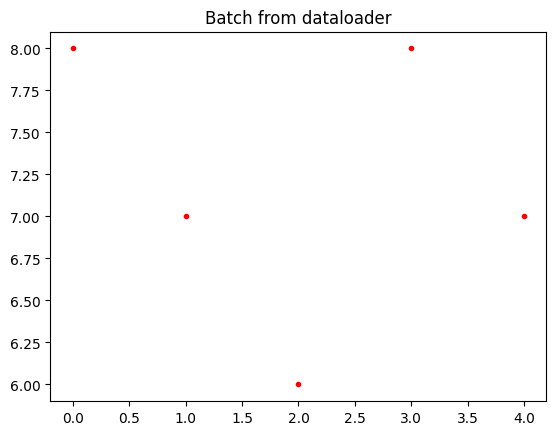

In [80]:
import matplotlib.pyplot as plt

def show_houses_batch(sample_batched):
    """Show house records for a batch of samples."""
    houses_batch = sample_batched
    batch_size = len(houses_batch) # This shows the number of houses in a single batch
    record_size = houses_batch.size(1) # This shows the dimensions of data for a single house

    for i in range(batch_size):
        plt.scatter(i, houses_batch[i, 4].numpy(), marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader_train):
    print(sample_batched)
    print(i_batch, len(sample_batched))

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_houses_batch(sample_batched)
        plt.ioff()
        plt.show()
        break

## Create the Neural Network

In [81]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


Create MPL structure

In [82]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(5, 20),
            nn.ReLU(),
            nn.Linear(20, 50),
            nn.ReLU(),
            nn.Linear(50, 20),
            nn.ReLU(),
            nn.Linear(20, 5),
            nn.ReLU(),
            nn.Linear(5, 1)
        )
    
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

Define Model

In [52]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=5, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=20, bias=True)
    (5): ReLU()
    (6): Linear(in_features=20, out_features=5, bias=True)
    (7): ReLU()
    (8): Linear(in_features=5, out_features=1, bias=True)
  )
)


## Training, Testing and Validating

Define loss function, learning rate, and optimizer

In [53]:
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
#loss_fn = nn.L1Loss() # mean absolute error
learning_rate = 0.00001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch: 0, Loss: 121169494016.0
Epoch: 10, Loss: 73921839104.0
Epoch: 20, Loss: 73793601536.0
Epoch: 30, Loss: 73654706176.0
Epoch: 40, Loss: 73542320128.0
Epoch: 50, Loss: 73416769536.0
Epoch: 60, Loss: 73311805440.0
Epoch: 70, Loss: 73186344960.0
Epoch: 80, Loss: 73068838912.0
Epoch: 90, Loss: 72949219328.0
MSE: 72849981440.00
RMSE: 269907.36


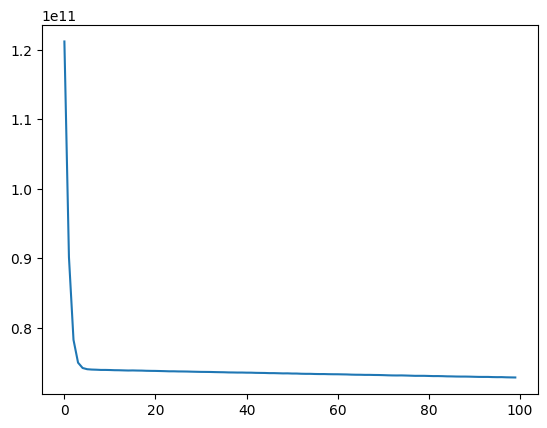

In [56]:
import copy
import tqdm

epochs = 100
batch_start = torch.arange(0, len(dataloader_train))
best_mse = np.inf   # init to infinity
# best_weights = None
history = []

for epoch in range(epochs):
    model.train().to(device)
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i_batch, sample_batched in enumerate(dataloader_train):
            sample_batched_X = sample_batched[:, :5].to(device)
            sample_batched_Y = sample_batched[:, 5:].to(device)

            # take a batch
            pred = model(sample_batched_X)

            # forward pass
            loss = loss_fn(pred, sample_batched_Y)

            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # print progress
            bar.set_postfix(mse=float(loss))

    # evaluate accuracy at end of each epoch
    model.eval()
    for i_batch, sample_batched in enumerate(dataloader_test):
      sample_batched_X = sample_batched[:, :5].to(device)
      sample_batched_Y = sample_batched[:, 5:].to(device)

      y_pred = model(sample_batched_X)
      mse = loss_fn(y_pred, sample_batched_Y)
      mse = float(mse)
      history.append(mse)
      if mse < best_mse:
          best_mse = mse
          # best_weights = copy.deepcopy(model.state_dict())
    
    if (epoch%10) == 0:
                print(f"Epoch: {epoch}, Loss: {round(mse, 3)}")

# restore model and return best accuracy
# model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

Best Validation MSE: 71606951936.0000
Best Validation RMSE: 267594.7532


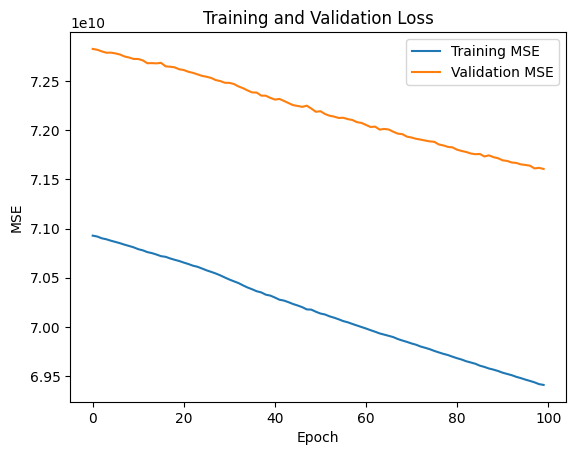

In [57]:
import copy
import torch
import tqdm
import numpy as np
import matplotlib.pyplot as plt

epochs = 100
batch_start = torch.arange(0, len(dataloader_train))
best_mse = np.inf  # Initialize to infinity
best_weights = None
history_train = []  # Track training loss
history_val = []    # Track validation loss

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0  # Initialize train loss for this epoch
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i_batch, sample_batched in enumerate(dataloader_train):
            sample_batched_X = sample_batched[:, :5].to(device)
            sample_batched_Y = sample_batched[:, 5:].to(device)

            # Forward pass
            pred = model(sample_batched_X)
            loss = loss_fn(pred, sample_batched_Y)

            # Backward pass and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track training loss
            train_loss += float(loss)  # Accumulate batch loss
            bar.set_postfix(mse=float(loss))  # Show current batch loss in progress bar
    
    # Calculate the average training loss for this epoch
    avg_train_loss = train_loss / len(dataloader_train)
    history_train.append(avg_train_loss)

    # Validation phase (no weight updates, so disable gradients)
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0  # Initialize validation loss for this epoch
    with torch.no_grad():  # No gradient calculation needed during validation
        for i_batch, sample_batched in enumerate(dataloader_test):
            sample_batched_X = sample_batched[:, :5].to(device)
            sample_batched_Y = sample_batched[:, 5:].to(device)

            # Forward pass (validation)
            y_pred = model(sample_batched_X)
            mse = loss_fn(y_pred, sample_batched_Y)

            # Accumulate validation loss
            val_loss += float(mse)
    
    # Calculate the average validation loss for this epoch
    avg_val_loss = val_loss / len(dataloader_test)
    history_val.append(avg_val_loss)

    # Print training and validation loss for this epoch
    # print(f"Epoch {epoch + 1}/{epochs} - Training MSE: {avg_train_loss:.4f}, Validation MSE: {avg_val_loss:.4f}")

    # Save the best model based on validation MSE
    if avg_val_loss < best_mse:
        best_mse = avg_val_loss
        # best_weights = copy.deepcopy(model.state_dict())

# Restore the model with the best weights (based on validation MSE)
# model.load_state_dict(best_weights)

# Print final results
print(f"Best Validation MSE: {best_mse:.4f}")
print(f"Best Validation RMSE: {np.sqrt(best_mse):.4f}")

# Plot training and validation loss over epochs
plt.plot(history_train, label='Training MSE')
plt.plot(history_val, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

KAN model training

In [83]:
!source activate Tsai
!pip install pykan
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [85]:
from kan import *
kan_model = KAN(width=[1, 2, 1], grid=5, k=3, seed=2, device=device)
# kan_model.plot()
print(kan_model)

checkpoint directory created: ./model
saving model version 0.0
MultKAN(
  (act_fun): ModuleList(
    (0-1): 2 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-1): 2 x Symbolic_KANLayer()
  )
)


Define loss function, learning rate, and optimizer

In [88]:
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
#loss_fn = nn.L1Loss() # mean absolute error
learning_rate = 0.00001
optimizer = optim.Adam(kan_model.parameters(), lr=learning_rate)

Best Validation MSE: 421431410688.0000
Best Validation RMSE: 649177.4878


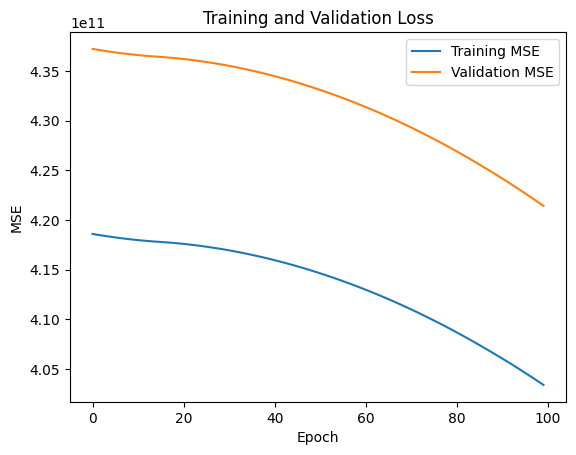

In [89]:
import copy
import torch
import tqdm
import numpy as np
import matplotlib.pyplot as plt

epochs = 100
batch_start = torch.arange(0, len(dataloader_train))
best_mse = np.inf  # Initialize to infinity
best_weights = None
history_train = []  # Track training loss
history_val = []    # Track validation loss

for epoch in range(epochs):
    kan_model.train()  # Set the model to training mode
    train_loss = 0.0  # Initialize train loss for this epoch
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i_batch, sample_batched in enumerate(dataloader_train):
            sample_batched_X = sample_batched[:, :5].to(device)
            sample_batched_Y = sample_batched[:, 5:].to(device)

            # Forward pass
            pred = kan_model(sample_batched_X)
            loss = loss_fn(pred, sample_batched_Y)

            # Backward pass and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track training loss
            train_loss += float(loss)  # Accumulate batch loss
            bar.set_postfix(mse=float(loss))  # Show current batch loss in progress bar
    
    # Calculate the average training loss for this epoch
    avg_train_loss = train_loss / len(dataloader_train)
    history_train.append(avg_train_loss)

    # Validation phase (no weight updates, so disable gradients)
    kan_model.eval()  # Set the model to evaluation mode
    val_loss = 0.0  # Initialize validation loss for this epoch
    with torch.no_grad():  # No gradient calculation needed during validation
        for i_batch, sample_batched in enumerate(dataloader_test):
            sample_batched_X = sample_batched[:, :5].to(device)
            sample_batched_Y = sample_batched[:, 5:].to(device)

            # Forward pass (validation)
            y_pred = kan_model(sample_batched_X)
            mse = loss_fn(y_pred, sample_batched_Y)

            # Accumulate validation loss
            val_loss += float(mse)
    
    # Calculate the average validation loss for this epoch
    avg_val_loss = val_loss / len(dataloader_test)
    history_val.append(avg_val_loss)

    # Print training and validation loss for this epoch
    # print(f"Epoch {epoch + 1}/{epochs} - Training MSE: {avg_train_loss:.4f}, Validation MSE: {avg_val_loss:.4f}")

    # Save the best model based on validation MSE
    if avg_val_loss < best_mse:
        best_mse = avg_val_loss
        best_weights = copy.deepcopy(model.state_dict())

# # Restore the model with the best weights (based on validation MSE)
# kan_model.load_state_dict(best_weights)

# Print final results
print(f"Best Validation MSE: {best_mse:.4f}")
print(f"Best Validation RMSE: {np.sqrt(best_mse):.4f}")

# Plot training and validation loss over epochs
plt.plot(history_train, label='Training MSE')
plt.plot(history_val, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()